In [44]:
from pymatgen.io.cif import CifParser
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.decomposition import PCA
from karateclub.node_embedding.neighbourhood.deepwalk import DeepWalk


import numpy as np


def cif_to_graph(cif_path, distance_threshold, plot=False, label_font_size=14):
    """
    Convert a CIF file to a MEGNet graph representation.

    Parameters:
    - cif_path: str, path to the CIF file
    - distance_threshold: float, maximum distance between atoms to consider an edge (bond)
    - plot: bool, if True, plot the graph
    - label_font_size: int, font size for plot labels

    Returns:
    - graph_data: dict, containing graph information compatible with MEGNet model
    """
    
    # Load the CIF file
    structure = Structure.from_file(cif_path)

    # Initialize graph and features
    G = nx.Graph()
    node_features = []
    edge_features = []
    global_state_features = [0, 0]  # Placeholder for global information exchange

    # Add nodes (atoms) to the graph
    for i, site in enumerate(structure):
        atomic_number = site.specie.number
        label = f"${site.specie.symbol}_{i}$"
        G.add_node(i, element=site.specie.symbol, position=site.frac_coords, Z=atomic_number, label=label)
        node_features.append([atomic_number])

    # Define Gaussian basis function for expanded distance
    def gaussian_expanded_distance(r, r0, sigma=0.5):
        return np.exp(-(r - r0)**2 / sigma**2)

    # Add edges (bonds) to the graph
    r_values = np.linspace(0, 5, 100)
    for i, site1 in enumerate(structure):
        for j, site2 in enumerate(structure):
            if i < j:
                distance = round(structure.get_distance(i, j),2)
                if distance < distance_threshold:
                    expanded_distances = [gaussian_expanded_distance(distance, r0) for r0 in r_values]
                    G.add_edge(i, j, distance=distance, weight=distance)
                    edge_features.append(expanded_distances)

    # Plotting the graph
    if plot:
        pos = {i: site.frac_coords[:2] for i, site in enumerate(structure)}
        labels = nx.get_node_attributes(G, 'label')
        edge_labels = nx.get_edge_attributes(G, 'weight')

        nx.draw(G, pos, labels=labels, node_size=500, node_color="skyblue", font_size=label_font_size)
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=label_font_size)

        plt.title('Material Structure Graph')
        plt.show()

    # Prepare graph data for MEGNet
    graph_data = {
        'node_features': node_features,
        'edge_features': edge_features,
        'global_state_features': global_state_features
    }
    

    return graph_data



In [88]:
from sklearn.metrics.pairwise import cosine_similarity
def graph_to_embedding(graph_data):
    """
    Convert graph data into a simple embedding vector by aggregating node and edge features.

    Parameters:
    - graph_data: dict, containing graph information with node_features, edge_features, and global_state_features

    Returns:
    - embedding: np.array, a simple embedding vector for the graph
    """

    # Aggregate node features
    node_features = np.array(graph_data['node_features'])
    node_embedding = np.mean(node_features, axis=0)  # Simple mean of node features

    # Aggregate edge features
    edge_features = np.array(graph_data['edge_features'])
    if len(edge_features) > 0:
        edge_embedding = np.mean(edge_features, axis=0)  # Simple mean of edge features
    else:
        edge_embedding = np.zeros_like(node_embedding)  # No edges, return zeros

    # Combine with global state features
    global_state_features = np.array(graph_data['global_state_features'])
    embedding = np.concatenate([node_embedding, edge_embedding, global_state_features])
    print(embedding.shape)
    return embedding

def cif_cosine_sim(cif_path1, cif_path2, distance_threshold=3.0):
    """
    Load two CIF files and return the cosine similarity of their graph embeddings.

    Parameters:
    - cif_path1: str, path to the first CIF file
    - cif_path2: str, path to the second CIF file
    - distance_threshold: float, threshold for considering an edge

    Returns:
    - similarity: float, cosine similarity between graph embeddings of the two CIF files
    """
    embedding1 = cif_to_embedding(cif_path1, distance_threshold)
    embedding2 = cif_to_embedding(cif_path2, distance_threshold)
    similarity = cosine_similarity([embedding1], [embedding2])[0][0]
    return similarity



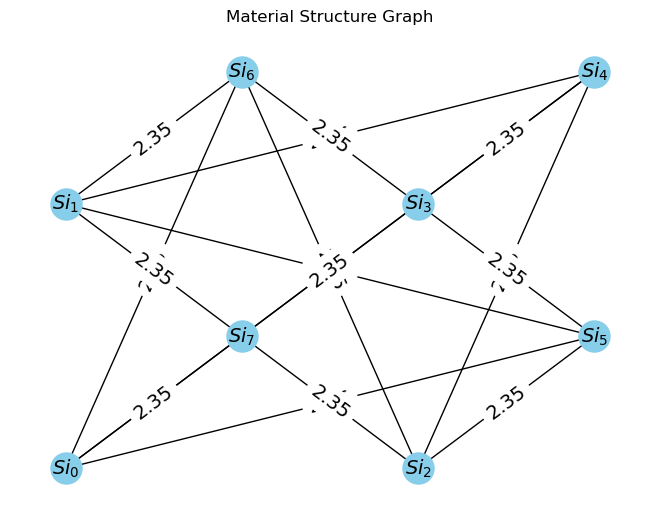

[[2.54938188e-10 6.52175061e-10 1.63467429e-09 ... 5.16354364e-12
  1.82489992e-12 6.31928589e-13]
 [2.54938188e-10 6.52175061e-10 1.63467429e-09 ... 5.16354364e-12
  1.82489992e-12 6.31928589e-13]
 [2.54938188e-10 6.52175061e-10 1.63467429e-09 ... 5.16354364e-12
  1.82489992e-12 6.31928589e-13]
 ...
 [2.54938188e-10 6.52175061e-10 1.63467429e-09 ... 5.16354364e-12
  1.82489992e-12 6.31928589e-13]
 [2.54938188e-10 6.52175061e-10 1.63467429e-09 ... 5.16354364e-12
  1.82489992e-12 6.31928589e-13]
 [2.54938188e-10 6.52175061e-10 1.63467429e-09 ... 5.16354364e-12
  1.82489992e-12 6.31928589e-13]]
(16, 100)
(103,)
Cosine Similarity: 0.7629065004662652


c:\Users\12162\anaconda3\Lib\site-packages\pymatgen\io\cif.py:1224: UserWarning: Issues encountered while parsing CIF: 2 fractional coordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: " + "\n".join(self.warnings))


In [93]:

# Outside the function, read CIF file and get the structure
path = r"C:\Users\12162\Documents\GreenDynamics\data\AMS_DATA.cif"

# print(structure)
name = "Al"
# Call the function with the structure
graph = cif_to_graph(cif_path=path, distance_threshold=3, plot=True, label_font_size=14)
print(np.array(graph['edge_features']))
print(np.array(graph['edge_features']).shape)
embedding = graph_to_embedding(graph)
# print(embedding.shape)

# Example usage:
cif_path1 = r".\data\AMS_DATA.cif"
cif_path2 = r".\data\9014004.cif"
similarity = cif_cosine_sim(cif_path1, cif_path2)
print("Cosine Similarity:", similarity)





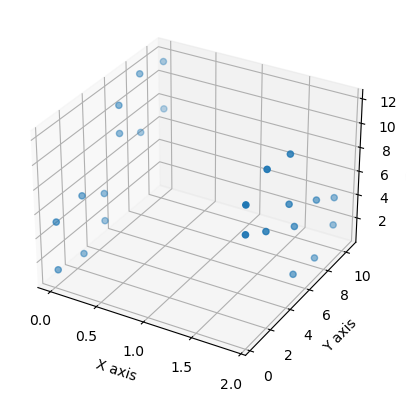

In [9]:
import ase
from ase.io import read
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Replace 'your_file.cif' with the path to your CIF file
path = r"C:\Users\12162\Documents\GreenDynamics\data\Si3.cif"

# Read the structure from the CIF file
atoms = read(path)

# Create a 3D figure
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Extract positions of atoms
positions = atoms.get_positions()

# Extract x, y, z coordinates for plotting
x = positions[:, 0]
y = positions[:, 1]
z = positions[:, 2]

# Plot atoms in 3D
ax.scatter(x, y, z)

# Set labels for axes
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')

# Show the plot
plt.show()


In [ ]:
from pymatgen.io.cif import CifParser
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.decomposition import PCA
from karateclub.node_embedding.neighbourhood.deepwalk import DeepWalk
from pymatgen.io.cif import CifParser
from pymatgen.core.lattice import Lattice
from pymatgen.core.interface import Interface
from megnet.utils.models import load_model
from pymatgen.core import Structure, Lattice
# Outside the function, read CIF file and get the structure
path = r"C:\Users\12162\Documents\GreenDynamics\data\Al_300K.cif"

# print(structure)
name = "Al"
# Call the function with the structure
graph = cif_to_graph(path,name, 3, True,14)
print(graph)

NameError: name 'cif_to_graph' is not defined